# Data views

In [1]:
#PCA-fct Annelaura
from sklearn.decomposition import PCA
def runPCA(data, components = 2):
    result = {}
    X = data.copy()
    pca = PCA(n_components=components)
    pca.fit(X)
    X = pca.transform(X)
    var_exp = pca.explained_variance_ratio_
    args = {"x_title":"PC1"+" ({0:.2f})".format(var_exp[0]),"y_title":"PC2"+" ({0:.2f})".format(var_exp[1])}
    if components == 2:
        resultDf = pd.DataFrame(X, columns = ["x","y"])
    if components > 2:
        args.update({"z_title":"PC3"+str(var_exp[2])})
        resultDf = pd.DataFrame(X)
        cols = []
        if len(components)>3:
            cols = resultDf.columns[4:]
        resultDf.columns = ["x", "y", "z"] + cols
    result['pca'] = resultDf
    return resultDf, args

## Load Data 

Meta Data

In [2]:
import os
import ipywidgets as w
import pandas as pd
from config import PROCESSED_DATA, PREFIX_META
meta_data = pd.read_pickle(os.path.join(PROCESSED_DATA, PREFIX_META + '.pkl' ))
meta_data.head()

,index,Date,MS_instrument,LC,PID,ColumnLength,shortdate
SampleID,,,,,,,
408,20180713_QE8_nLC5_ASD_QC_Hela1_proteinGroups.txt,20180713,QE8,nLC5,ASD,NaN,201807
312,20180713_QE8_nLC5_ASD_QC_Hela2_proteinGroups.txt,20180713,QE8,nLC5,ASD,NaN,201807
281,20180713_QE8_nLC5_ASD_QC_Hela2_20190226172112_...,20180713,QE8,nLC5,ASD,NaN,201807
82,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_02_pro...,20190103,QE8,nLC0,LiNi,15.0,201901
161,20190103_QE8_nLC0_LiNi_QC_MNT_15cm_Hela_01_pro...,20190103,QE8,nLC0,LiNi,15.0,201901


Select imputed protein data for protein groups present in at least the available percentage of the samples

In [3]:
w_data = w.Dropdown(options= [x for x in os.listdir(os.path.join(PROCESSED_DATA)) if '.pkl' in x and not 'meta' in x])
w_data

Dropdown(options=('hela_imputed_proteins_50.pkl', 'hela_imputed_proteins_90.pkl'), value='hela_imputed_protein…

## PCA 
- How good is the reconstruction using the first two principal components?
    - it works relatively good on MNIST, also here?

### Explained Variance



In [4]:
data = pd.read_pickle(os.path.join(PROCESSED_DATA, w_data.value))

In [5]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca = pca.fit(data)
CDF_var_explained = np.cumsum(pca.explained_variance_ratio_)

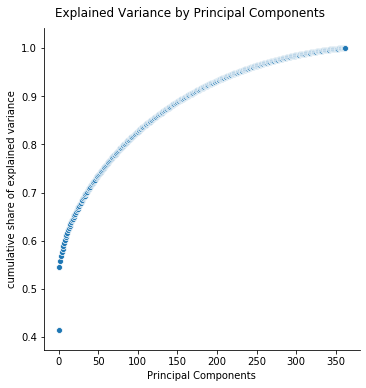

In [6]:
import seaborn
import matplotlib as plt
g = seaborn.relplot(data=pd.Series(CDF_var_explained))
g.set_axis_labels("Principal Components", "cumulative share of explained variance")
_ = g.fig.suptitle('Explained Variance by Principal Components', y=1.03)

In [7]:
print("90 percent of Variance is explained by first {} principal components".format(
       np.argmax(CDF_var_explained >= 0.9)
))

90 percent of Variance is explained by first 163 principal components


### First two Principal Components

In [8]:
n_components = 2
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
data_2PC = pca.fit_transform(data)

In [9]:
print("Variance share of PC1: {:.3f}, PC2: {:.3f}".format(*pca.explained_variance_ratio_))

Variance share of PC1: 0.414, PC2: 0.130


In [10]:
data_2PC = pd.DataFrame(data_2PC, index=data.index, columns=[f'PC{i}' for i in range(1,n_components+1)])
data_2PC.head()

,PC1,PC2
SampleID,,
408,-12.037074,-27.105675
281,-13.252902,-31.794649
82,34.371093,-3.456893
161,42.603377,2.525639
251,26.988896,-5.811818


### Plot Principal Components
- there must have been a change in HeLa batch in june 2019 
- there are also a few runs from before/after that month that falls in the wrong cluster

In [11]:
# PCA
# Original data
result, args = runPCA(data)
result.set_index(data.index, inplace = True)

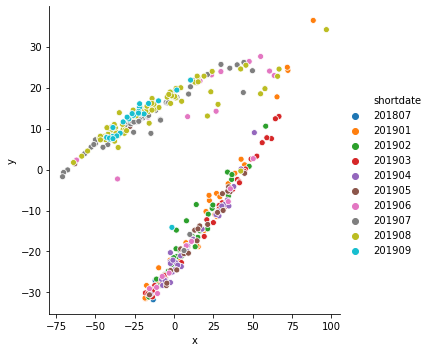

In [12]:
result = meta_data.join(result)
result['shortdate'] = result.shortdate.astype('category', copy=True)

seaborn.relplot(x='x', y='y', hue='shortdate', data=result )

### Other Plots (work in progress)

/Users/tzx804/env/fixjupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


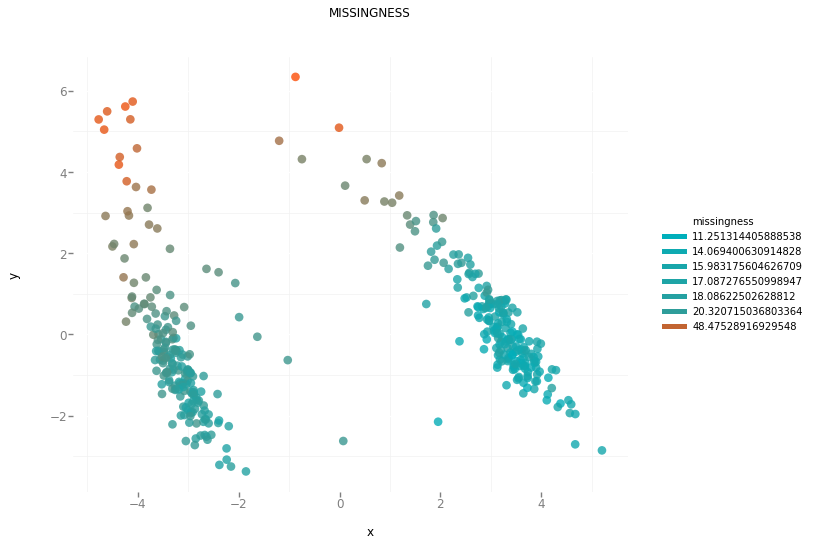

<ggplot: (326277733)>

In [5]:
# look at missing values
miss = x_50.T.isnull().sum().astype(float).tolist()
df = result_to_plot.loc[result_to_plot['variable']=='shortdate']
df['missingness']=[(mis/x_50.shape[1])*100 for mis in miss]
from ggplot import *
ggplot(aes(x = 'x', y='y', color='missingness'),data = df)+geom_point(size =75, alpha = 0.8) + scale_color_gradient(low = "#00AFBB", high = "#FC4E07")+theme_bw()+ggtitle('MISSINGNESS')

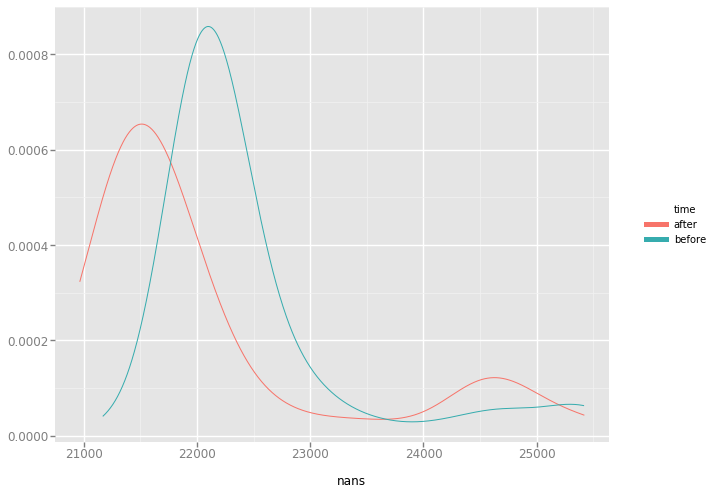

<ggplot: (320864569)>

In [6]:
# Make 'before' and 'after' datasets
labels['datetime'] = pd.to_datetime(labels.Date, format = '%Y%m%d')
labels['time'] = 'after'
labels.loc[labels['datetime']<'2019-06-01','time']='before'
# check number of nans
nonan = x.isnull().sum(axis = 1)
nonnan = pd.DataFrame(nonan)
nonnan.columns = ['nans']
nonnan['time']=labels['time']
#from ggplot import *
ggplot(aes(x='nans', color = 'time'), data = nonnan) + geom_density() #+ ylim(0,0.025)

## There are fewer identified proteins (more missingness) in the "old" HeLa

In [7]:
# datasets with 50% coverage for both 'before' and 'after'                

x_50_before = coverage(x.loc[labels['datetime']<'2019-06-01',:], 0.5,0.5)
print(x.loc[labels['datetime']<'2019-05-01',:].shape)
print(x_50_before.shape)
x_50_after = coverage(x.loc[labels['datetime']>='2019-06-01',:], 0.5,0.5)
print(x.loc[labels['datetime']>='2019-05-01',:].shape)
print(x_50_after.shape)

# Overlapping proteins
print('overlapping:',len(list(set(x_50_before.columns.tolist()) & set(x_50_after.columns.tolist()))))

(177, 25427)
(175, 2069)
(296, 25427)
(223, 2375)
overlapping: 1451


/Users/tzx804/env/fixjupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


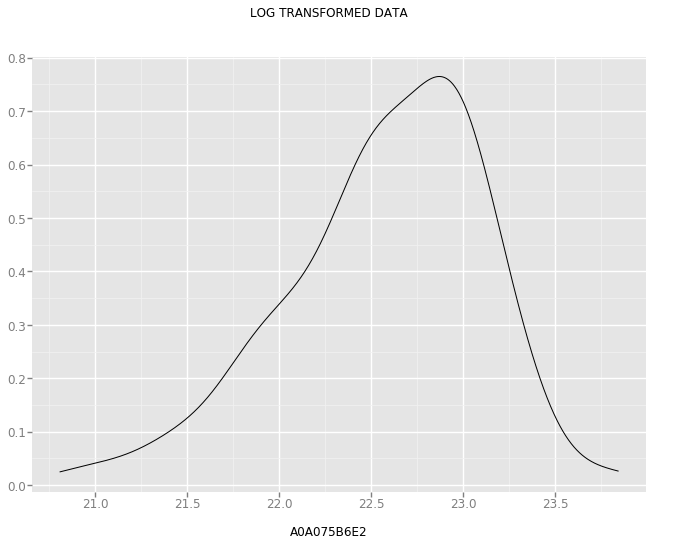

<ggplot: (321229681)>

In [8]:
# look at the distributions
from ggplot import *
ggplot(aes(x = 'A0A075B6E2'), data = x_50_before)+geom_density()+ggtitle('RAW DATA')
x_50_before_log = pd.DataFrame(np.log(x_50_before), columns = x_50_before.columns)
from ggplot import *
ggplot(aes(x = 'A0A075B6E2'), data = x_50_before_log)+geom_density()+ggtitle('LOG TRANSFORMED DATA')

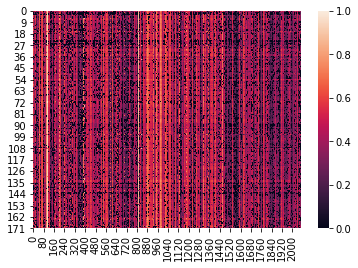

In [9]:
# heatmap of log trans, zeroone, and z-scaled data (before)
data_before_pca = log_z_zeroone_na(x_50_before)
sns.heatmap(data_before_pca)

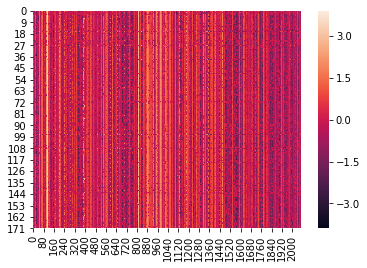

In [10]:
# heatmap of log trans and z-scaled data (before)
data_log_z_na = log_z_na(x_50_before)
sns.heatmap(data_log_z_na)

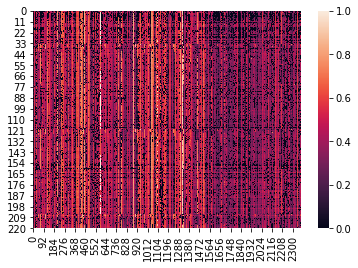

In [11]:
# heatmap of log trans and z-scaled data (after)
data_after_pca = log_z_zeroone_na(x_50_after)
sns.heatmap(data_after_pca)

In [12]:
## PCA
result, args = runPCA(data_before_pca)
result.set_index(x_50_before.index, inplace = True)

info = labels[['index','MS_instrument', 'LC','ColumnLength','shortdate']] # i have not included pid because there are so many different..
info['ColumnLength'] = labels.ColumnLength.astype(int).astype(str)
info = info.loc[x_50_before.index,:]
result_to_plot = pd.merge(result,info, left_index = True, right_index = True)
result_to_plot = pd.melt(result_to_plot, id_vars =['index','x','y'], value_vars =['MS_instrument','LC','ColumnLength','shortdate']) 

#from ggplot import *
#ggplot(aes(x = 'x', y='y', color = 'value'), data = result_to_plot)+geom_point()+theme_bw()+facet_grid('variable')

/Users/tzx804/env/fixjupyter/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


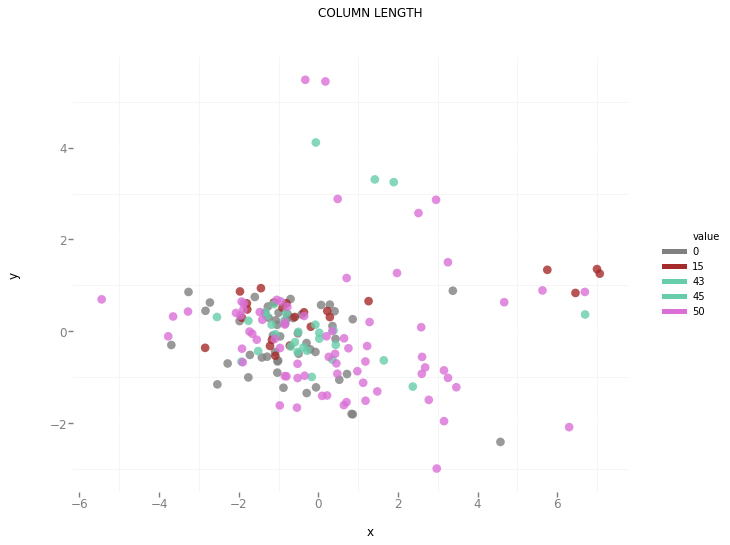

<ggplot: (321495873)>

In [13]:
# take a closer look at each
date_data = result_to_plot.loc[result_to_plot['variable']=='ColumnLength']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =75, alpha = 0.8)+theme_bw()+scale_color_manual(values = ['grey','brown','mediumaquamarine','mediumaquamarine','orchid'])+ggtitle('COLUMN LENGTH')


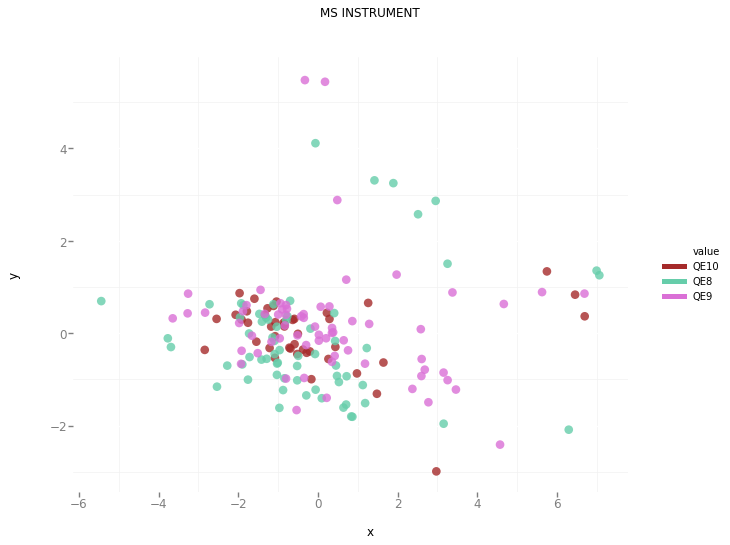

<ggplot: (321495889)>

In [14]:
date_data = result_to_plot.loc[result_to_plot['variable']=='MS_instrument']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =75, alpha = 0.8)+theme_bw()+scale_color_manual(values = ['brown','mediumaquamarine','orchid'])+ggtitle('MS INSTRUMENT')


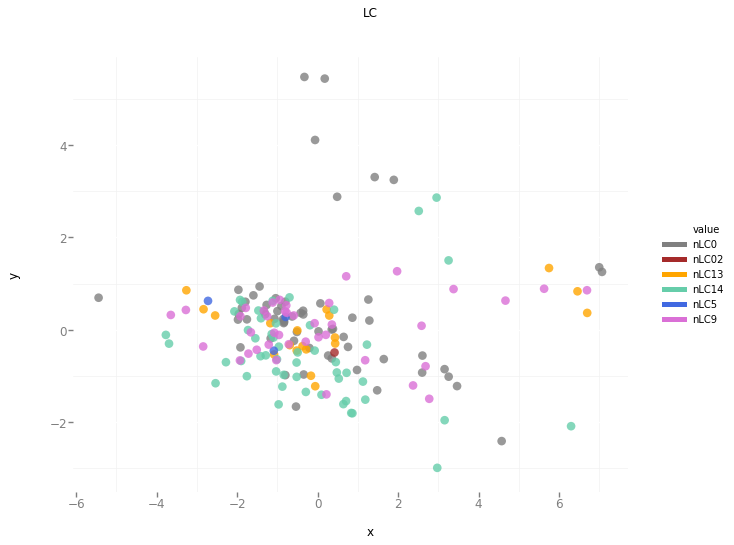

<ggplot: (323168493)>

In [15]:
date_data = result_to_plot.loc[result_to_plot['variable']=='LC']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =75, alpha = 0.8)+theme_bw()+scale_color_manual(values = ['grey','brown','orange','mediumaquamarine','royalblue','orchid'])+ggtitle('LC')


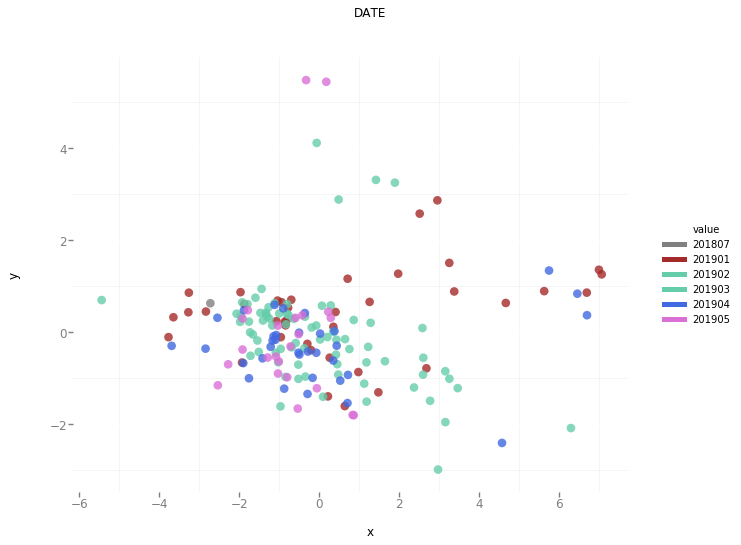

<ggplot: (323850165)>

In [16]:
# take a closer look at each
date_data = result_to_plot.loc[result_to_plot['variable']=='shortdate']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =75, alpha = 0.8)+theme_bw()+scale_color_manual(values = ['grey','brown','mediumaquamarine','mediumaquamarine','royalblue','orchid'])+ggtitle('DATE')


/Users/tzx804/env/fixjupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


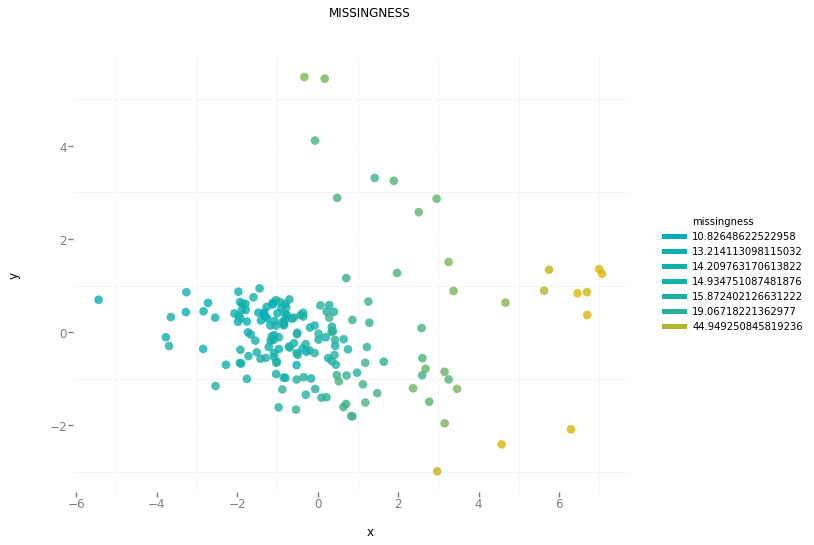

<ggplot: (321604677)>

In [17]:
# look at missing values
miss = x_50_before.T.isnull().sum().astype(float).tolist()
date_data = result_to_plot.loc[result_to_plot['variable']=='shortdate']
date_data['missingness']=[(mis/x_50_before.shape[1])*100 for mis in miss]
from ggplot import *
ggplot(aes(x = 'x', y='y', color='missingness'),data = date_data)+geom_point(size =75, alpha = 0.8) + scale_color_gradient(low = "#00AFBB", high = "#E7B800")+theme_bw()+ggtitle('MISSINGNESS')

In [18]:
# grouping according to missing values! --> look at x_90

x_90_before = coverage(x.loc[labels['datetime']<'2019-06-01',:], 0.9,0.9)
print(x_90_before.shape)
data_before_pca = log_z_zeroone_na(x_90_before)
result, args = runPCA(data_before_pca)
result.set_index(x_90_before.index, inplace = True)

info = labels[['index','MS_instrument', 'LC','ColumnLength','shortdate']] # i have not included pid because there are so many different..
info['ColumnLength'] = labels.ColumnLength.astype(int).astype(str)
info = info.loc[x_90_before.index,:]
result_to_plot = pd.merge(result,info, left_index = True, right_index = True)
result_to_plot = pd.melt(result_to_plot, id_vars =['index','x','y'], value_vars =['MS_instrument','LC','ColumnLength','shortdate']) 

(177, 232)


/Users/tzx804/env/fixjupyter/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


/Users/tzx804/env/fixjupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


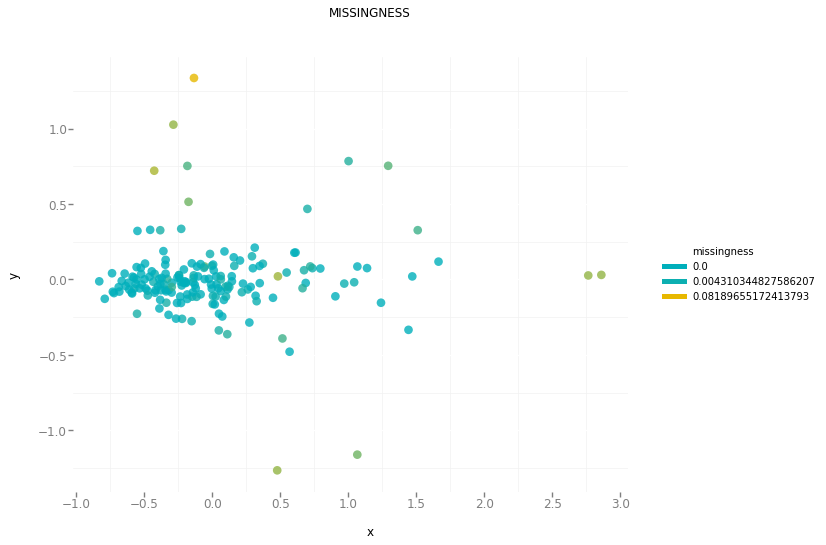

<ggplot: (321496041)>

In [19]:
# look at missing values
miss = x_90_before.T.isnull().sum().astype(float).tolist()
date_data = result_to_plot.loc[result_to_plot['variable']=='shortdate']
date_data['missingness']=[(mis/x_90_before.shape[1]) for mis in miss]
from ggplot import *
ggplot(aes(x = 'x', y='y', color='missingness'),data = date_data)+geom_point(size =75, alpha = 0.8) + scale_color_gradient(low = "#00AFBB", high = "#E7B800")+theme_bw()+ggtitle('MISSINGNESS')

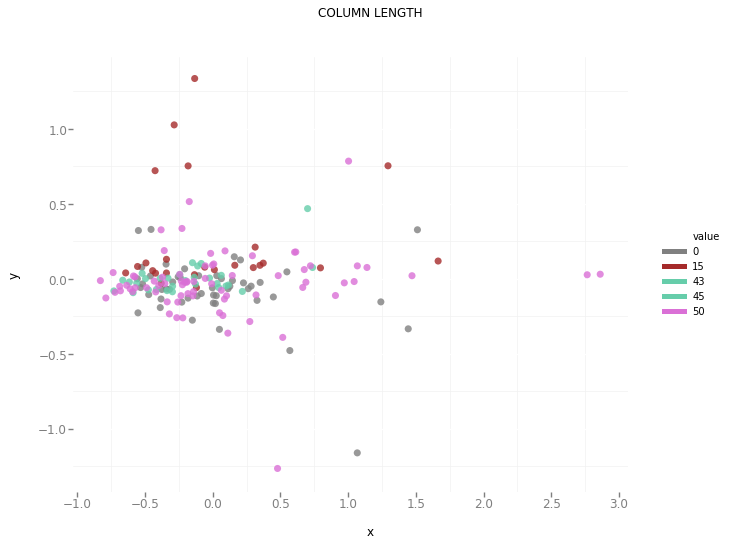

<ggplot: (324199573)>

In [20]:
# take a closer look at each
date_data = result_to_plot.loc[result_to_plot['variable']=='ColumnLength']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =50, alpha = 0.8)+theme_bw()+scale_color_manual(values = ['grey','brown','mediumaquamarine','mediumaquamarine','orchid'])+ggtitle('COLUMN LENGTH')


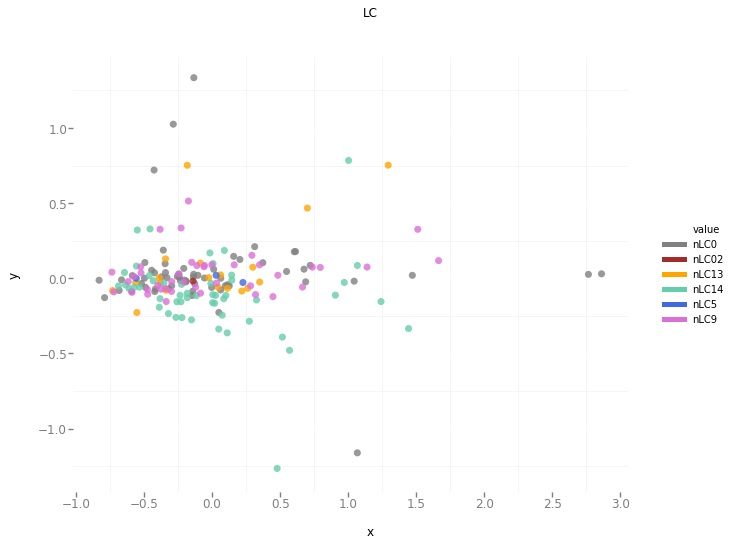

<ggplot: (321915165)>

In [21]:
date_data = result_to_plot.loc[result_to_plot['variable']=='LC']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =50, alpha = 0.8)+theme_bw()+scale_color_manual(values = ['grey','brown','orange','mediumaquamarine','royalblue','orchid'])+ggtitle('LC')


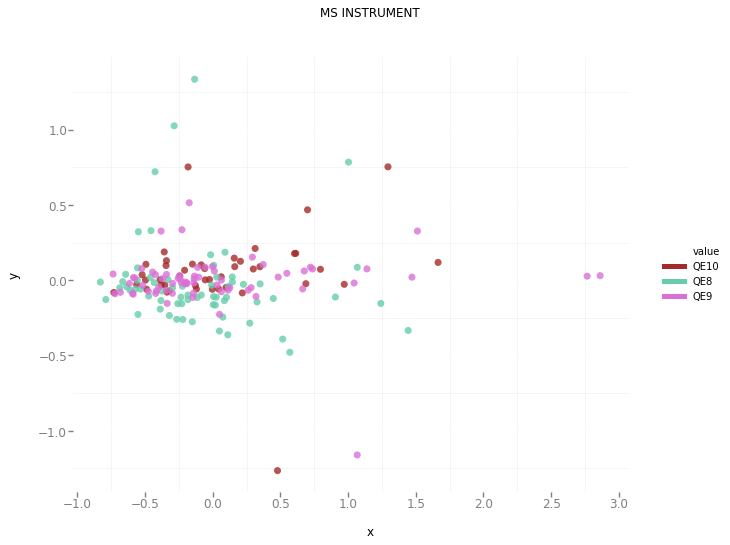

<ggplot: (324366777)>

In [22]:
date_data = result_to_plot.loc[result_to_plot['variable']=='MS_instrument']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =50, alpha = 0.8)+theme_bw()+scale_color_manual(values = ['brown','mediumaquamarine','orchid'])+ggtitle('MS INSTRUMENT')


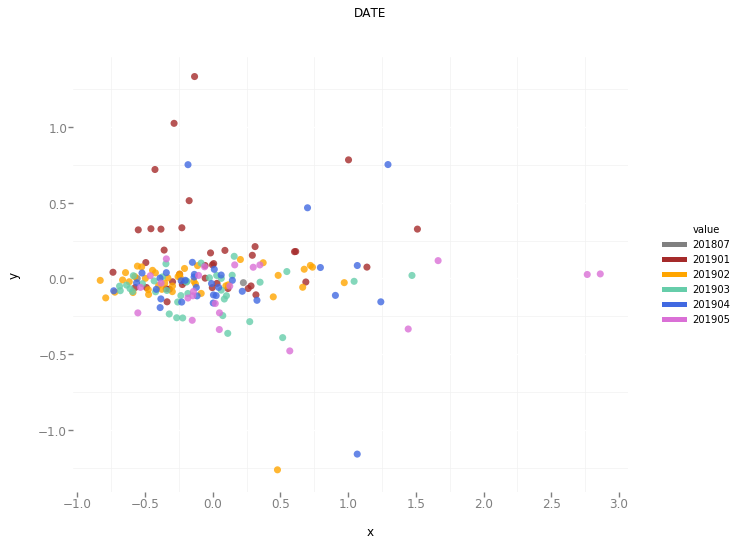

<ggplot: (324895665)>

In [23]:
date_data = result_to_plot.loc[result_to_plot['variable']=='shortdate']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =50, alpha = 0.8)+theme_bw()+scale_color_manual(values = ['grey','brown','orange','mediumaquamarine','royalblue','orchid'])+ggtitle('DATE')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

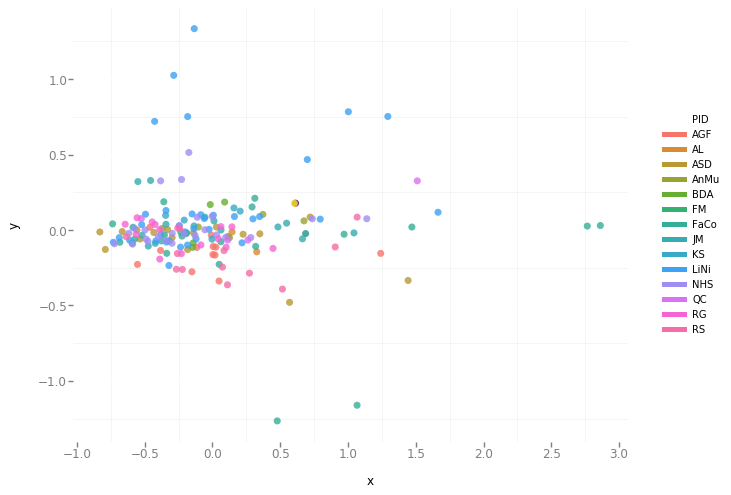

<ggplot: (322617129)>

In [24]:
info = labels[['PID']]
info = info.loc[x_90_before.index,:]
result_to_plot = pd.merge(result,info, left_index = True, right_index = True)
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'PID'), data = result_to_plot)+geom_point(size =50, alpha = 0.8)+theme_bw() #+scale_color_manual(values = ['brown','mediumaquamarine','orchid'])+ggtitle('MS INSTRUMENT')


In [25]:
## PCA
x_90_after = coverage(x.loc[labels['datetime']>='2019-06-01',:], 0.9,0.9)
print(x.loc[labels['datetime']>='2019-06-01',:].shape)
print(x_90_after.shape)
data_after_pca = log_z_zeroone_na(x_90_after)

result, args = runPCA(data_after_pca)
result.set_index(x_90_after.index, inplace = True)

info = labels[['index','MS_instrument', 'LC','ColumnLength','shortdate','PID']] 
info['ColumnLength'] = labels.ColumnLength.astype(int).astype(str)
info = info.loc[x_90_after.index,:]
result_to_plot = pd.merge(result,info, left_index = True, right_index = True)
result_to_plot = pd.melt(result_to_plot, id_vars =['index','x','y'], value_vars =['MS_instrument','LC','ColumnLength','shortdate','PID']) 

(272, 25427)
(236, 157)


/Users/tzx804/env/fixjupyter/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


/Users/tzx804/env/fixjupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


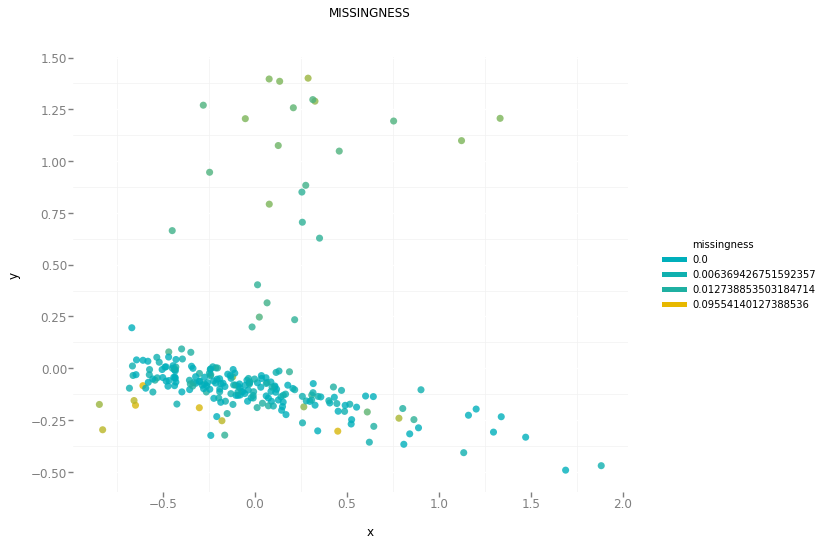

<ggplot: (325708109)>

In [26]:
# look at missing values
miss = x_90_after.T.isnull().sum().astype(float).tolist()
date_data = result_to_plot.loc[result_to_plot['variable']=='shortdate']
date_data['missingness']=[(mis/x_90_after.shape[1]) for mis in miss]
from ggplot import *
ggplot(aes(x = 'x', y='y', color='missingness'),data = date_data)+geom_point(size =50, alpha = 0.8) + scale_color_gradient(low = "#00AFBB", high = "#E7B800")+theme_bw()+ggtitle('MISSINGNESS')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

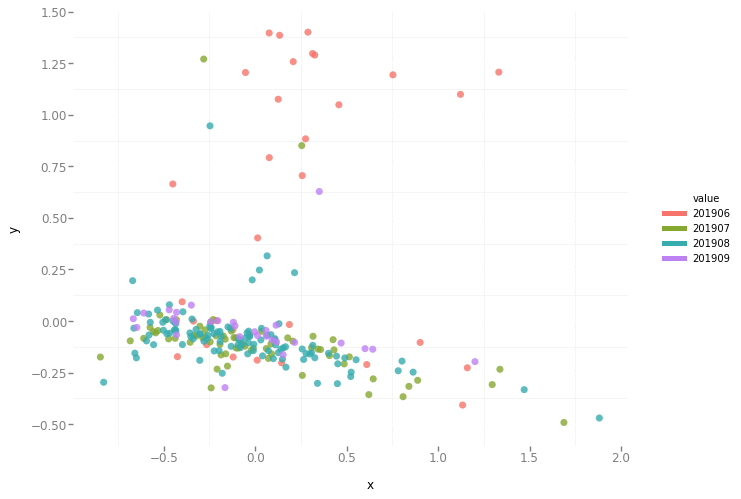

<ggplot: (324307533)>

In [27]:
date_data = result_to_plot.loc[result_to_plot['variable']=='shortdate']
from ggplot import *
ggplot(aes(x = 'x', y='y',color = 'value'), data = date_data)+geom_point(size =50, alpha = 0.8)+theme_bw()#+scale_color_manual(values = ['grey','brown','orange','mediumaquamarine','royalblue','orchid'])+ggtitle('DATE')
